In [1]:
import os
# 纯transformer单点预测架构
from DataLoader import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
from torch.utils.data import DataLoader
from ProcessData import process_data3

In [46]:
class Transformer(torch.nn.Module):
    # d_model : number of features
    def __init__(self, train_length):
        super(Transformer, self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2, 128, 8)
        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.positional_embedding = torch.nn.Embedding(100, 128)
        # self.decoder_layer = nn.TransformerDecoderLayer(d_model=feature_size, nhead=1, dropout=dropout)
        # self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.decoder = torch.nn.Linear(128, 1)
        self.train_length = train_length
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)==1)).transpose(0,1)
        mask = mask.float().masked_fill(mask==0, float('-inf')).masked_fill(mask==1, float(0.0))
        return mask

    def forward(self, x, src):
        mask = self._generate_square_subsequent_mask(x.shape[1]).cuda()
        # print(src.shape)
        # print(x.shape)
        z = torch.cat((src.unsqueeze(1), x.unsqueeze(1)), dim=1) #[batch, feature, time_step]
        z_embedding = self.input_embedding(z).permute(2,0,1) #[time_step, batch, feature]
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)

        input_embedding = z_embedding+positional_embeddings
        output = self.transformer_encoder(input_embedding, mask)
        # output = self.decoder(tgt=src, memory=output)
        output = self.decoder(output.permute(1,0,2))
        return output

In [47]:
train_length = 30
forcast_window = 7
csv_name = "Palo Alto"

In [48]:
train_dataset, test_dataset, X_train_time, X_test_time = process_data3(csv_name,train_length, forcast_window, time=True)

F:\我的文件\EV充电需求\Deep-Spatio-Temporal-Forecasting\data_handler.py:22: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  Palo_alto = pd.read_csv("data/Palo Alto/ChargePoint Data CY20Q4.csv")


<class 'numpy.ndarray'>
normalized.shape: (3444,)
matrix_lags.shape: (3407, 37)
train_dataset: (3400, 37)
test_dataset: (7, 37)
time_list: (3444,)
all_time_lags.shape: (3407, 37)


In [49]:
criterion = torch.nn.MSELoss() # mae误差

In [50]:
def Dp(y_pred,y_true,q): # softmax更新
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [51]:
def Rp_num_den(y_preds,y_trues,q): # RPloss
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [52]:
train_data = SensorDataset2(train_dataset, X_train_time, train_length, forcast_window)
test_data = SensorDataset2(test_dataset, X_test_time, train_length, forcast_window)

torch.Size([3400, 31])
torch.Size([3400, 7])
torch.Size([3400, 37])
(3400, 37)
torch.Size([7, 31])
torch.Size([7, 7])
torch.Size([7, 37])
(7, 37)


F:\我的文件\EV充电需求\Deep-Spatio-Temporal-Forecasting\DataLoader.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


In [53]:
train_dl = DataLoader(train_data,batch_size=32,shuffle=True) # [batch_size, feature_size]
test_dl = DataLoader(test_data,batch_size=1)

In [54]:
model = Transformer(train_length).cuda()

In [55]:
lr = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 20000

In [56]:
def train_epoch(model,train_dl,train_length=30):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,src,tar, _) in enumerate(train_dl):
        # [batch, time]
        src_in = src[:,:-1]
        src_out = src[:,1:]
        optimizer.zero_grad()
        output = model(x[:,:train_length].cuda().float(),src_in.cuda().float())
        # assert 1==0
        # output [batch, time, feature]
        # print('train:',output[0,(train_length-1):(train_length+forcast_window-1)])
        loss = criterion(output.squeeze(-1),src_out.cuda()) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        # print('梯度：', loss.grad)
        optimizer.step()
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        # assert 1== 0
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [57]:
def test_epoch(model,test_dl,train_length=30, forcast_window=7):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,src,tar,_) in enumerate(test_dl):
            src_in = src[:,:-1]
            src_out = src[:,1:]
            next_input = torch.tensor(src_in)
            all_predictions = []
            for i in range(forcast_window):
                output = model(x[:,:next_input.shape[1]].cuda(),next_input.cuda())
                if all_predictions == []:
                    all_predictions = output[:,-1]
                else:
                    all_predictions = torch.cat((all_predictions, output[:,-1].detach()), dim=-1)
                next_input = torch.cat((next_input.cuda(), output[:,-1].detach()), dim=-1)

            # print(output.shape) #[batch, seq_len, feature] [128, 48, 1]
            # print('test:', output[0,(train_length-1):(train_length+forcast_window-1)])
            for p,o in zip(all_predictions.cpu().numpy(),tar.numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
    return Rp

In [58]:
train_epoch_loss = []
# eval_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []

    l_t = train_epoch(model,train_dl,train_length)
    train_loss.append(l_t)

    Rp = test_epoch(model,test_dl,train_length, forcast_window)

    if Rp_best > Rp:
        Rp_best = Rp

    train_epoch_loss.append(np.mean(train_loss))

    print("Epoch {}: Train loss: {} \t R_p={}".format(e+1,
                                                             np.mean(train_loss),Rp))

F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4668\1142579477.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_input = torch.tensor(src_in)


Epoch 1: Train loss: 0.17412132678663028 	 R_p=0.9901838101871178
Epoch 2: Train loss: 0.05354778458966929 	 R_p=0.6228793103662954
Epoch 3: Train loss: 0.017041672779356733 	 R_p=0.46352729094199296
Epoch 4: Train loss: 0.014662163233494058 	 R_p=0.42186440522083635
Epoch 5: Train loss: 0.01308054179610575 	 R_p=0.48662486085226
Epoch 6: Train loss: 0.012283063155105885 	 R_p=0.4554812073031883
Epoch 7: Train loss: 0.011694520490572733 	 R_p=0.41162605548696163
Epoch 8: Train loss: 0.011272111525211265 	 R_p=0.40748566697576594
Epoch 9: Train loss: 0.011043112854308942 	 R_p=0.39920492775607924
Epoch 10: Train loss: 0.010714887772851131 	 R_p=0.4379959659457196
Epoch 11: Train loss: 0.01036646583062761 	 R_p=0.4475905745823667
Epoch 12: Train loss: 0.010100047906093737 	 R_p=0.4105444424946188
Epoch 13: Train loss: 0.009999661618734107 	 R_p=0.44618180569884397
Epoch 14: Train loss: 0.009655173326678135 	 R_p=0.44319168570737666
Epoch 15: Train loss: 0.00946701660314027 	 R_p=0.443285

In [59]:
print("Rp best={}".format(Rp_best))

Rp best=0.36547569082373926


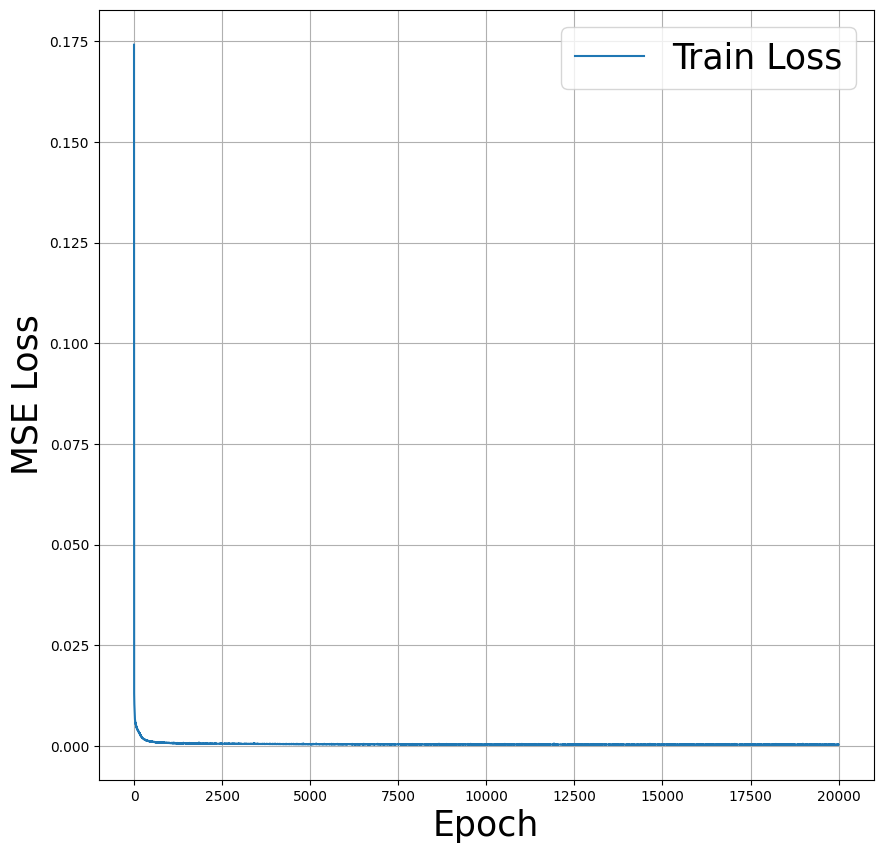

In [60]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.legend(['Train Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.grid()
plt.show()

In [62]:
torch.save(model, 'save_model4/best_model_20000.pth')

In [70]:
test_model = torch.load('save_model4/best_model_20000.pth')

In [63]:
def change_to_date(date_num): # 更改数字日期到真实日期
    date_num = date_num.cpu().numpy()
    date_list = []
    for date in date_num:
        date_list.append(str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:8])
    return date_list

7


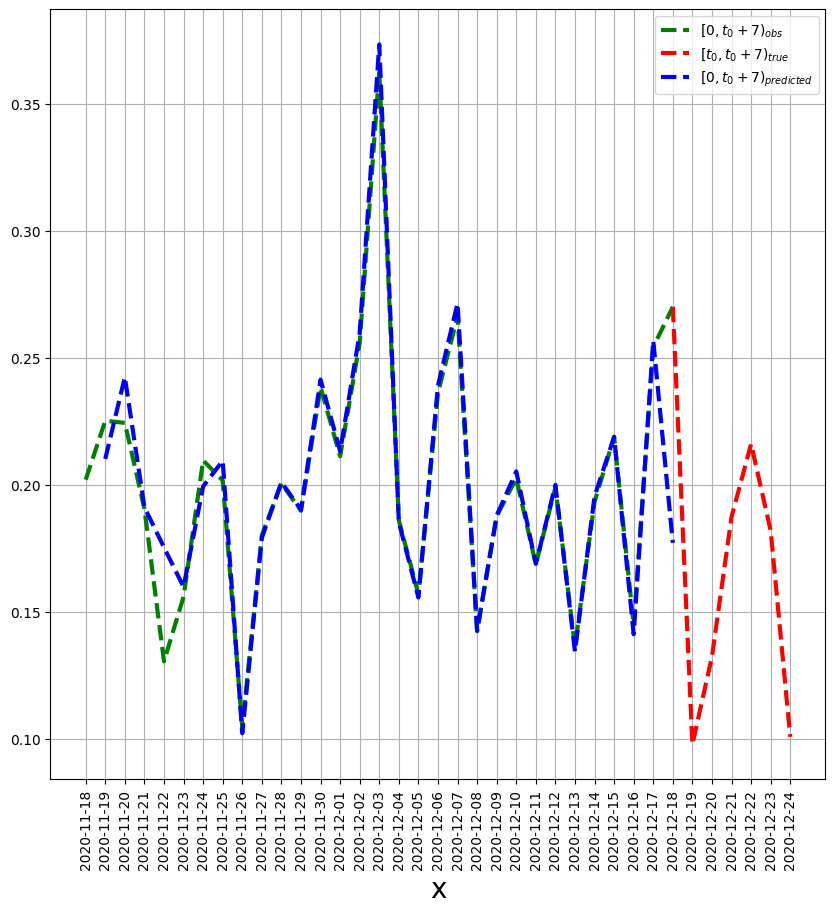

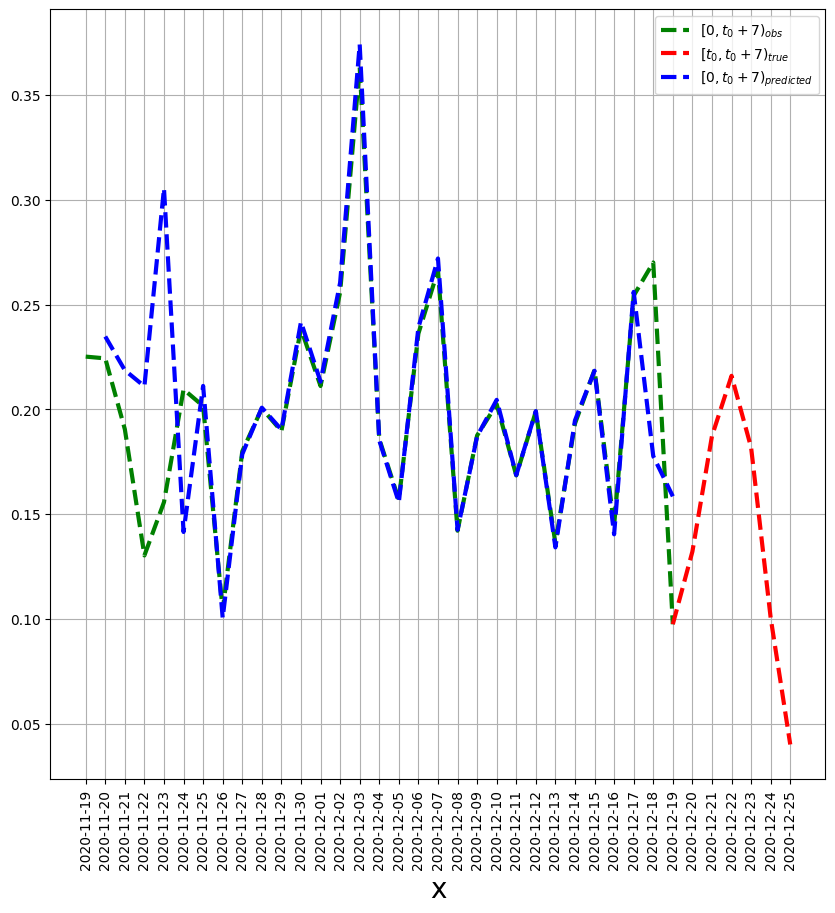

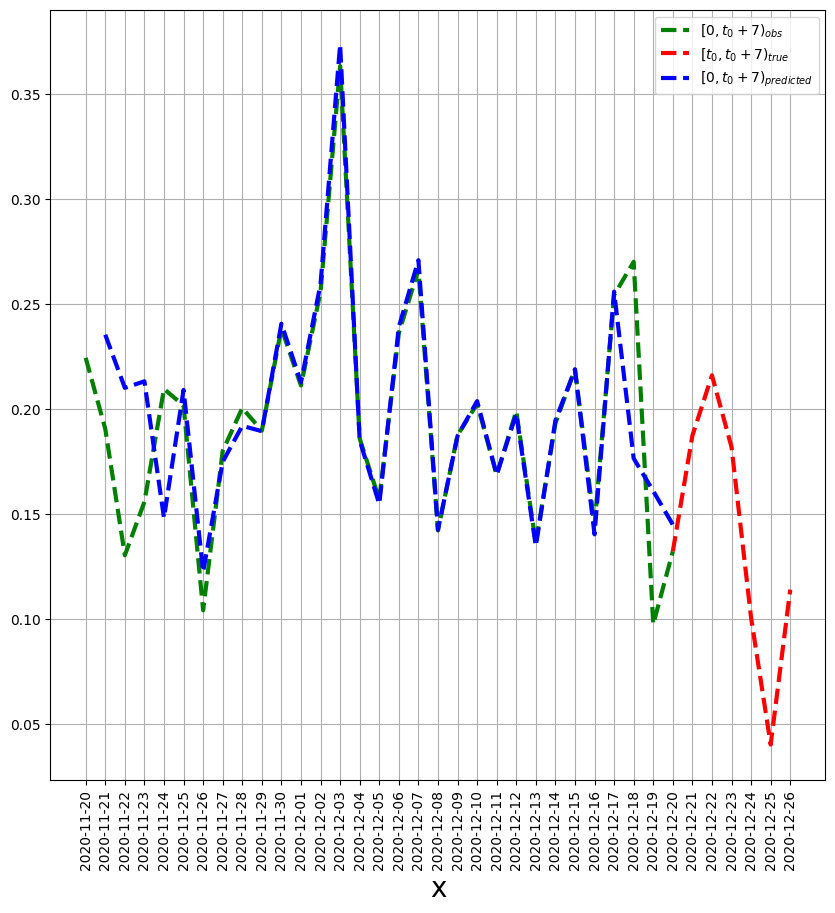

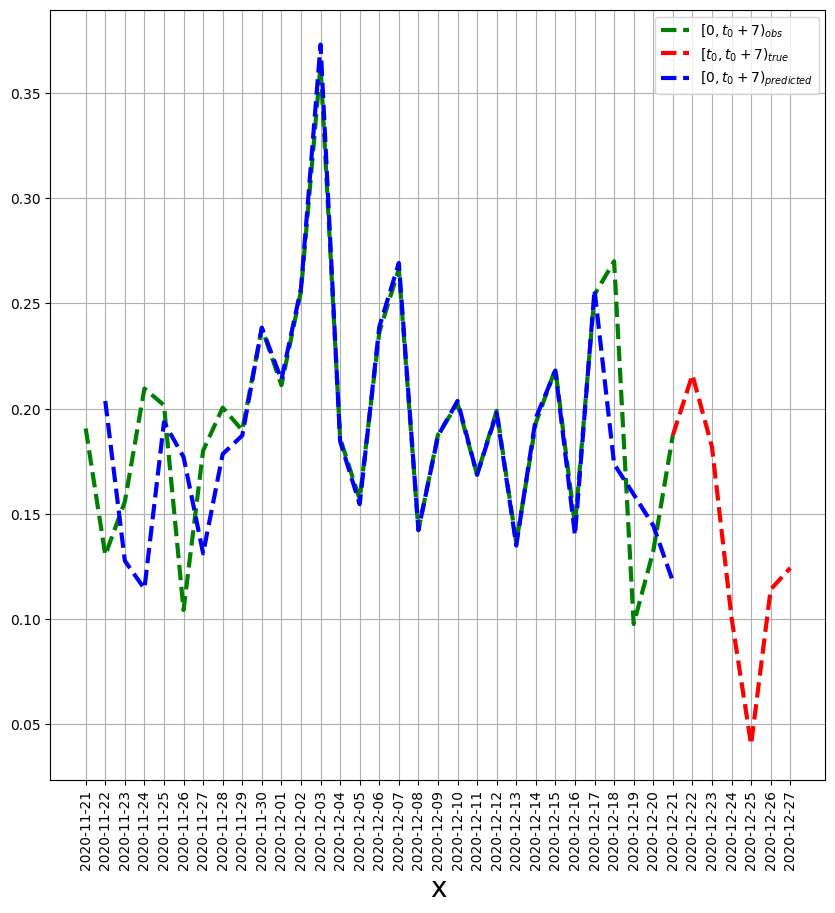

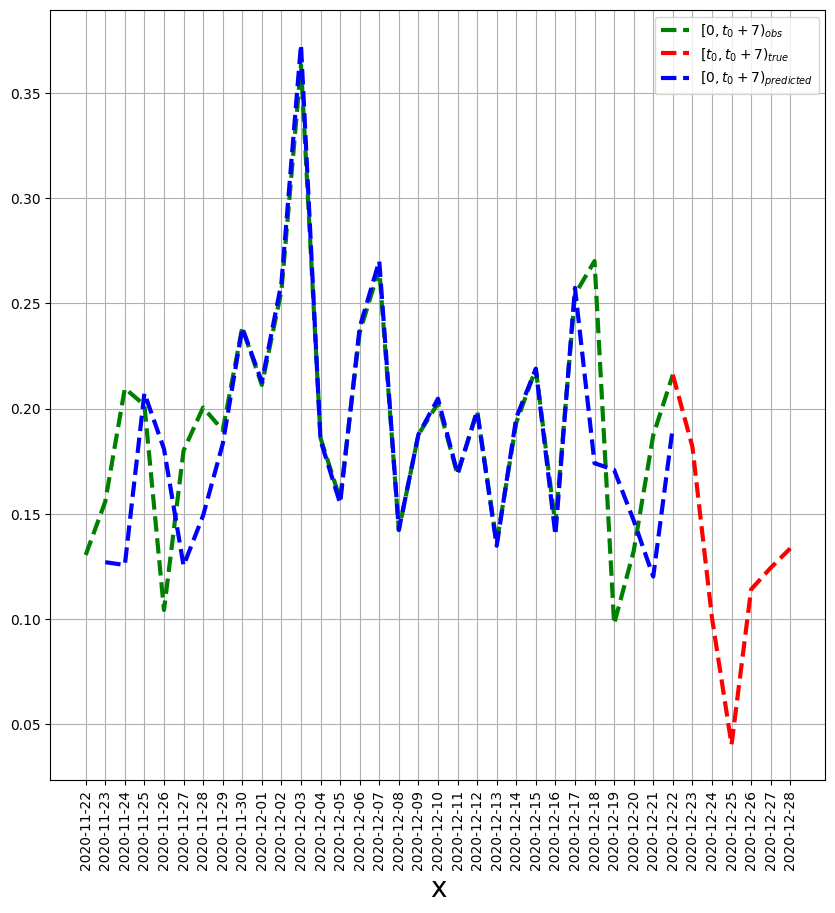

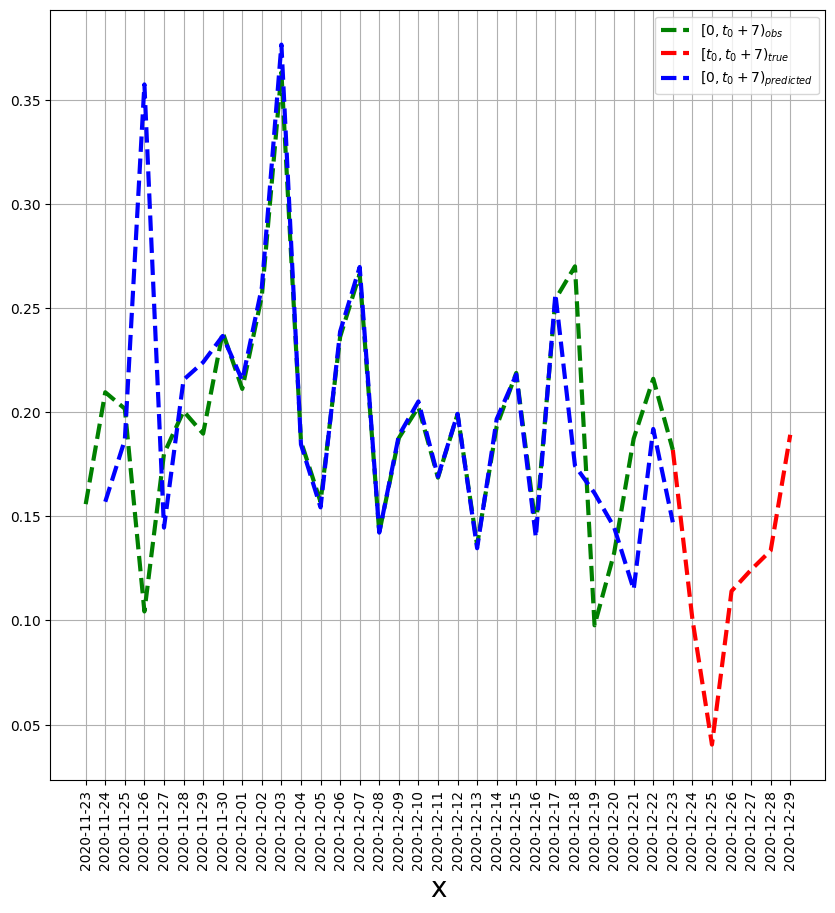

In [73]:
n_plots = 5
with torch.no_grad():
    model.eval()
    test_model.eval()
    print(len(test_dl))
    for step,(x,src, tar, times) in enumerate(test_dl):
        src_in = src[:,:-1]
        src_out = src[:,1:]
        output = test_model(x[:,:src_in.shape[1]].cuda().float(),src_in.cuda().float())
        # x[batch, seq_len]
        # y[batch, seq_len]
        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            data_list = change_to_date(times[0])
            plt.xticks(x[0], data_list)
            plt.xticks(rotation=90)
            plt.plot(x[0,:src.shape[1]],src[0].numpy(),'g--',linewidth=3)
            plt.plot(x[0,train_length:train_length+forcast_window],tar[0], 'r--' ,linewidth=3)
            plt.plot(x[0,1:src.shape[1]],output[0,:].cpu().detach().squeeze(-1).numpy(),'b--',linewidth=3) # not missing data
            # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+{7})_{obs}$","$[t_0,t_0+{7})_{true}$","$[0,t_0+{7})_{predicted}$"])
            plt.grid()
            plt.show()

7


F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


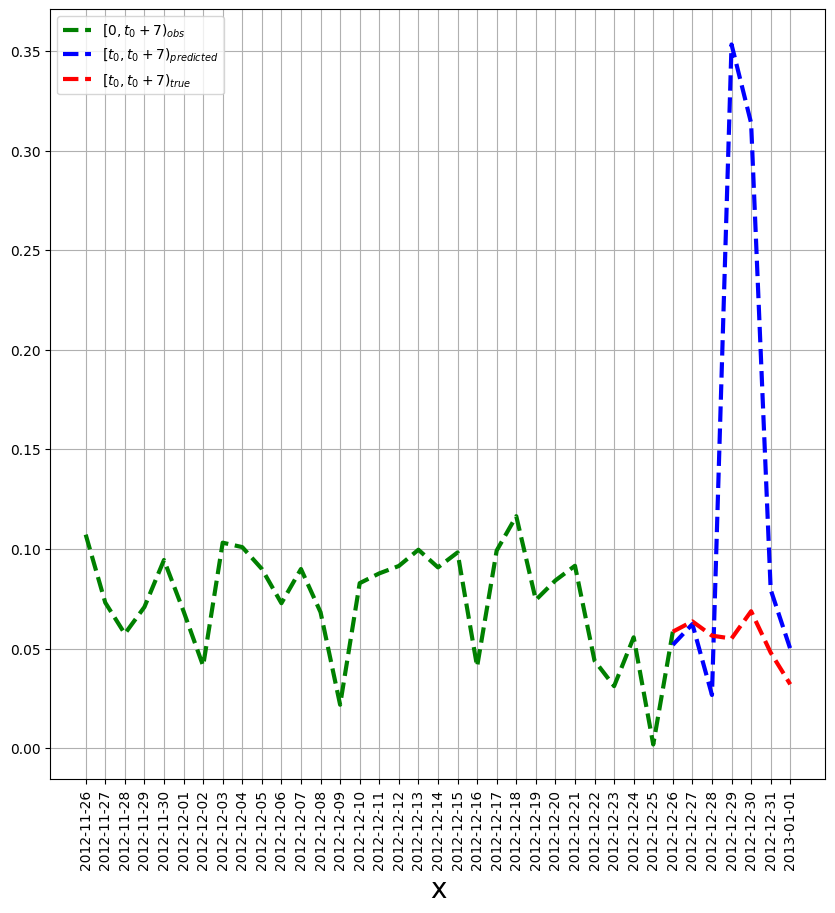

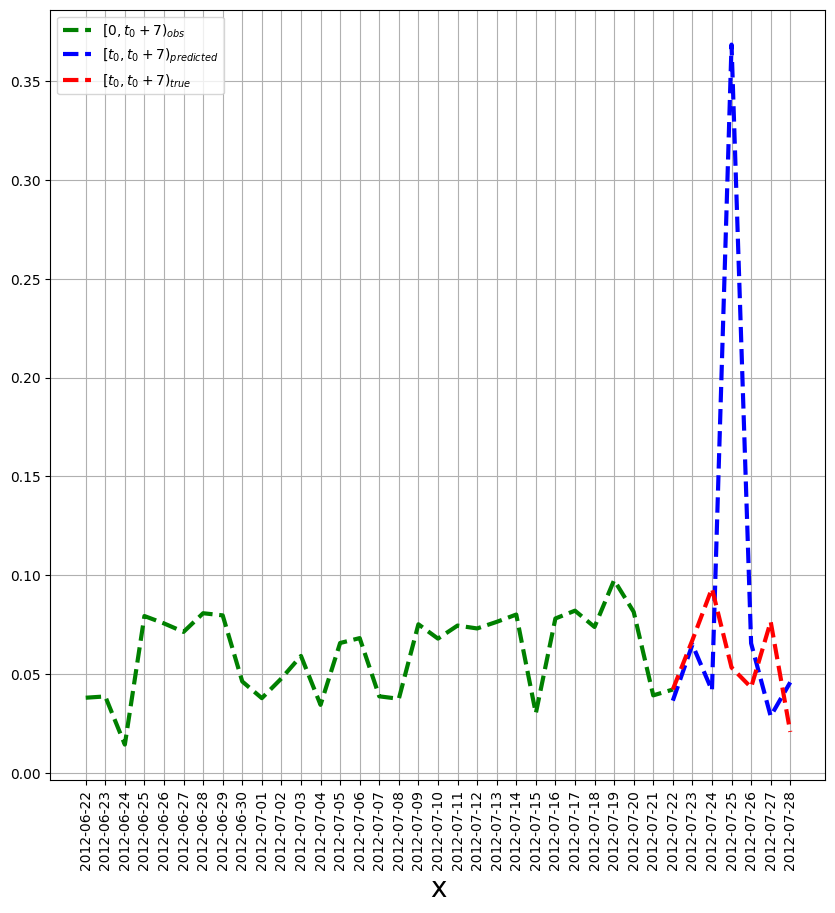

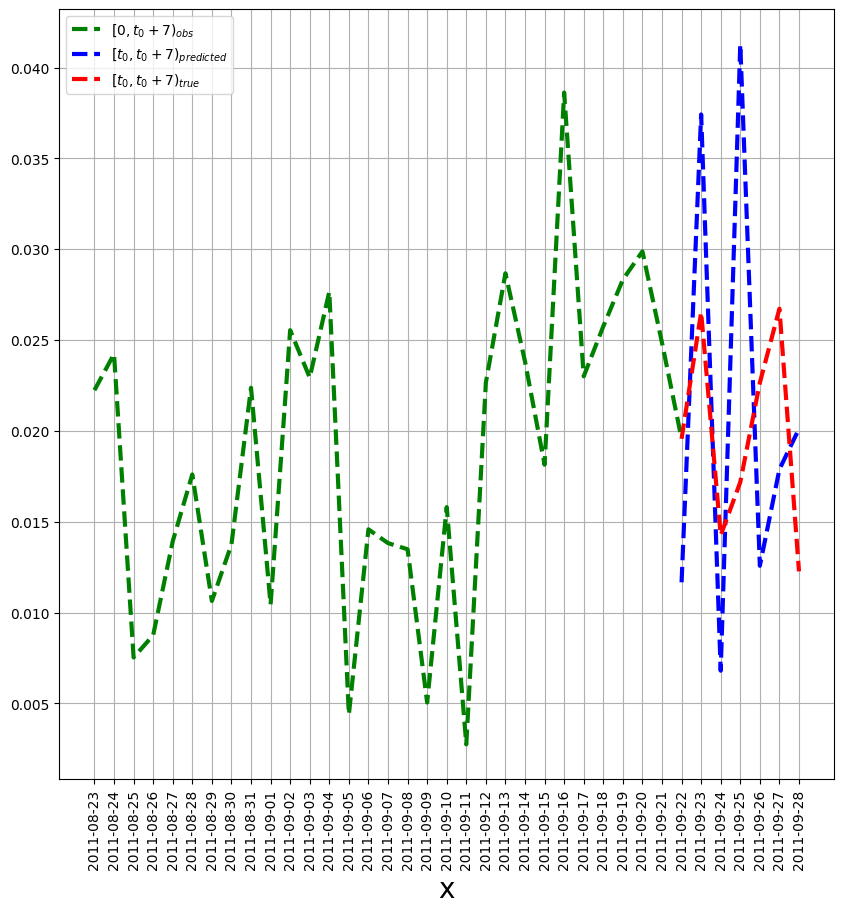

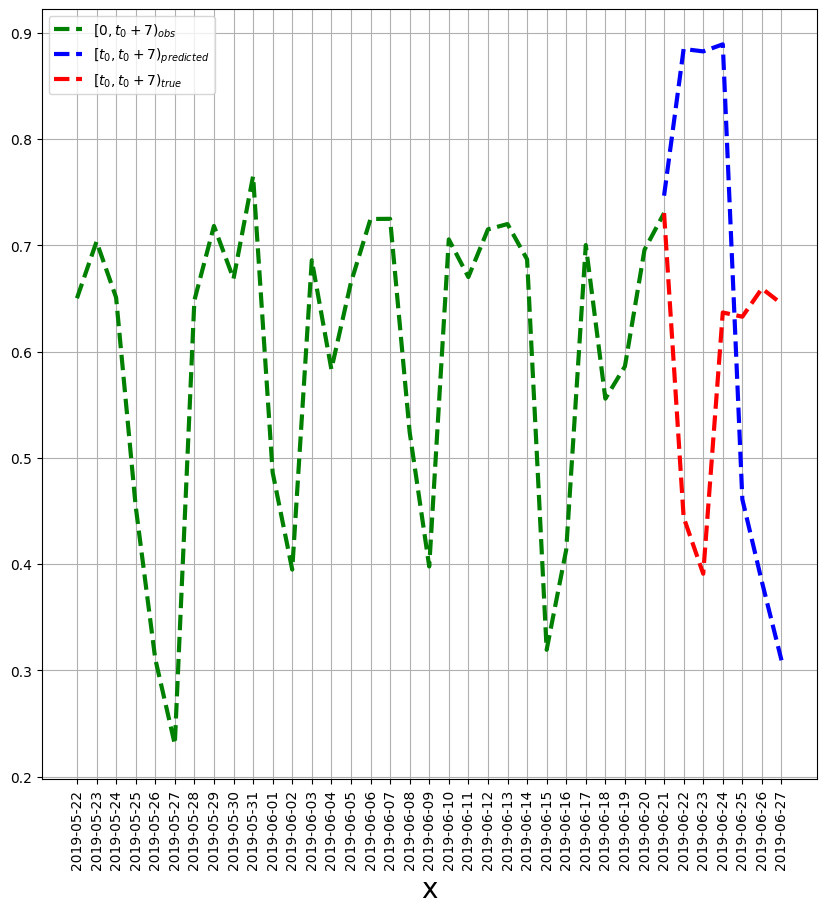

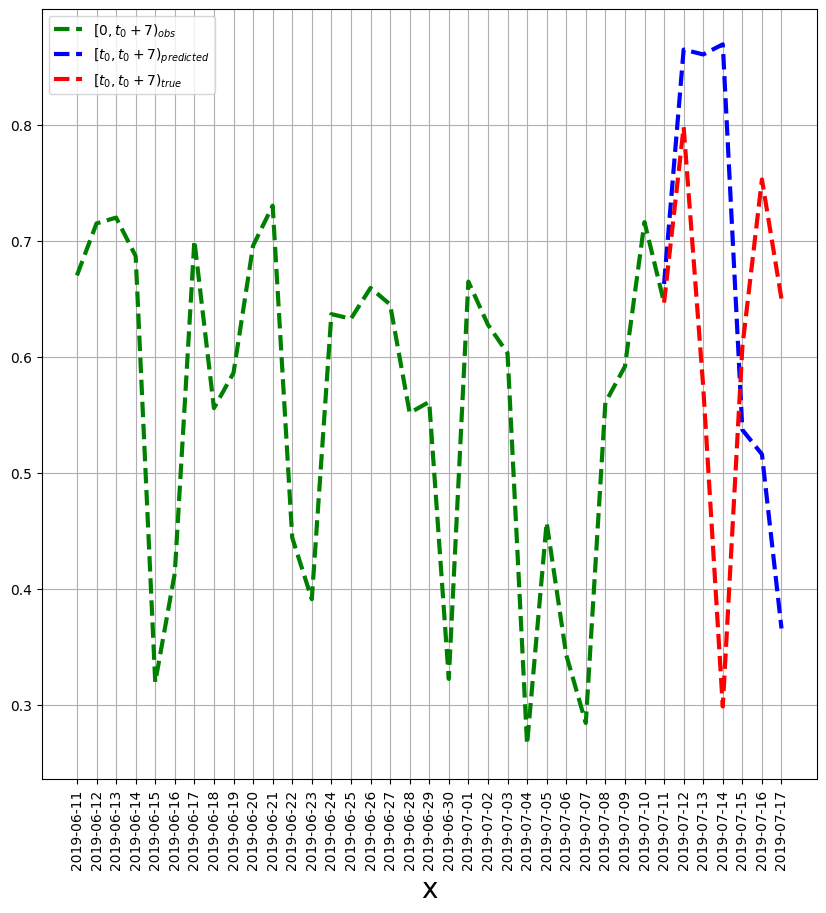

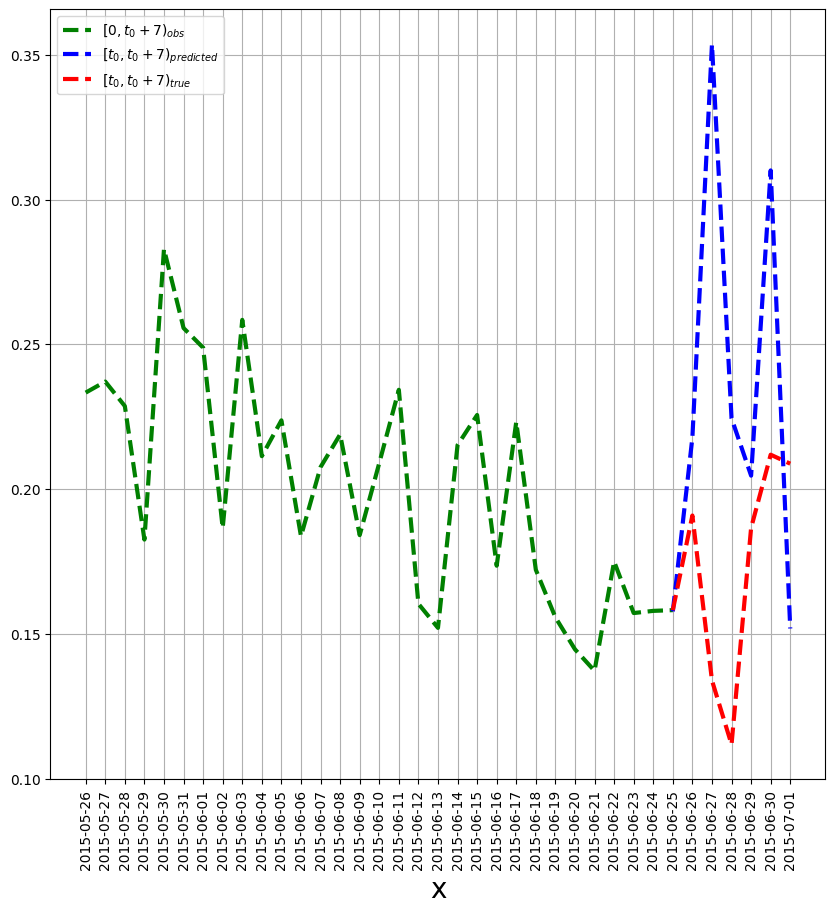

In [72]:
n_plots = 5
with torch.no_grad():
    model.eval()
    test_model.eval()
    print(len(test_dl))
    for step,(x,src, tar, times) in enumerate(train_dl):
        src_in = src[:,:-1]
        src_out = src[:,1:]
        next_input = src_in
        all_predictions = []
        for i in range(forcast_window):
            output = test_model(x[:,:next_input.shape[1]].cuda().float(),next_input.cuda().float())
            if all_predictions==[]:
                all_predictions = output[:,-1]
            else:
                all_predictions = torch.cat((all_predictions, output[:,-1].detach()),dim=-1)
            next_input = torch.cat((next_input.cuda(), output[:,-1]), dim=-1)
        # x[batch, seq_len]
        # y[batch, seq_len]
        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            data_list = change_to_date(times[0])
            plt.xticks(x[0], data_list)
            plt.xticks(rotation=90)
            plt.plot(x[0][:src.shape[1]].cpu().detach().squeeze().numpy(),src[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
            # plt.plot(x[0]+forcast_window,tar[0].cpu().detach().numpy(),'g--',linewidth=3)
            plt.plot(x[0][train_length:train_length+forcast_window],all_predictions[0,:].cpu().detach().numpy(),'b--',linewidth=3)
            plt.plot(x[0][train_length:train_length+forcast_window],
                     tar[0], 'r--', linewidth=3)# not missing data
            # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+{7})_{obs}$","$[t_0,t_0+{7})_{predicted}$","$[t_0,t_0+{7})_{true}$"])
            plt.grid()
            plt.show()